In [1]:
import sys
import os
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, LayerNorm, global_mean_pool
from torch_geometric.data import DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt

from dataset import SparseMatrixDataset

In [ ]:
dataset_name = "matrices_more_distributions"

In [2]:
class GCN_NET(nn.Module):
    def __init__(self, features, classes):
        super(GCN_NET, self).__init__()
        self.n1conv1 = GCNConv(features, 256)
        self.n1ln1 = LayerNorm(256)
        self.n1drop1 = nn.Dropout(0.1)
        self.n1conv2 = GCNConv(256, 256)
        self.n1ln2 = LayerNorm(256)
        self.n1drop2 = nn.Dropout(0.1)

        self.n2conv1 = GCNConv(features, 256)
        self.n2ln1 = LayerNorm(256)
        self.n2drop1 = nn.Dropout(0.1)
        self.n2conv2 = GCNConv(256, 256)
        self.n2ln2 = LayerNorm(256)
        self.n2drop2 = nn.Dropout(0.1)

        self.linear1 = nn.Linear(512, 128)
        self.linear2 = nn.Linear(128, classes) # class should be one for regression


    def forward(self, data):
        # network 1
        n1 = data["m1"]
        n1_x, n1_edge_index = n1.x, n1.edge_index

        n1_x = self.n1conv1(n1_x, n1_edge_index)
        n1_x = self.n1ln1(n1_x)
        n1_x = F.relu(n1_x)
        n1_x = self.n1drop1(n1_x)

        n1_x = self.n1conv2(n1_x, n1_edge_index)
        n1_x = self.n1ln2(n1_x)
        n1_x = F.relu(n1_x)
        n1_x = self.n1drop2(n1_x)

        n1_x = global_mean_pool(n1_x, n1.batch)

        # network 2
        n2 = data["m2"]
        n2_x, n2_edge_index = n2.x, n2.edge_index

        n2_x = self.n2conv1(n2_x, n2_edge_index)
        n2_x = self.n2ln1(n2_x)
        n2_x = F.relu(n2_x)
        n2_x = self.n2drop1(n2_x)

        n2_x = self.n2conv2(n2_x, n2_edge_index)
        n2_x = self.n2ln2(n2_x)
        n2_x = F.relu(n2_x)
        n2_x = self.n2drop2(n2_x)

        n2_x = global_mean_pool(n2_x, n2.batch)

        # merge networks
        x = torch.cat([n1_x, n2_x], dim=1)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

In [3]:
dataset = SparseMatrixDataset(root="../dataset", name=dataset_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dataset info: Features={dataset.num_node_features}, Classes={dataset.num_classes}")

# Initialize model and data loaders
model = GCN_NET(dataset.num_node_features, dataset.num_classes).to(device)

# Split dataset into training, validation, and test sets
torch.manual_seed(123456789)
num_graphs = len(dataset)
num_training, num_validation = int(num_graphs * 0.7), int(num_graphs * 0.15)
num_test = num_graphs - num_training - num_validation
training_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [num_training, num_validation, num_test])

train_loader = DataLoader(training_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)

Read matrix results from ../dataset/csv/matrices_more_distributions.csv
Processing matrix:  1.71529462647303E+018
	Read matrix from  ../dataset/matrices_more_distributions/1715294626473032621_m1.mtx
edge_index length:  2432
x shape = torch.Size([400, 16])
x shape = torch.Size([400, 16])
y shape = torch.Size([1])
Data object before return: Data(x=[400, 16], edge_index=[2, 2432], y=[1], num_nodes=400)
	Read matrix from  ../dataset/matrices_more_distributions/1715294626476796086_m2.mtx
edge_index length:  2714
x shape = torch.Size([400, 16])
x shape = torch.Size([400, 16])
y shape = torch.Size([1])
Data object before return: Data(x=[400, 16], edge_index=[2, 2714], y=[1], num_nodes=400)
Processing matrix:  1.71529462672693E+018
	Read matrix from  ../dataset/matrices_more_distributions/1715294626726929863_m1.mtx
edge_index length:  20000
x shape = torch.Size([600, 16])
x shape = torch.Size([600, 16])
y shape = torch.Size([1])
Data object before return: Data(x=[600, 16], edge_index=[2, 20000

Processing...


edge_index length:  20000
x shape = torch.Size([400, 16])
x shape = torch.Size([400, 16])
y shape = torch.Size([1])
Data object before return: Data(x=[400, 16], edge_index=[2, 20000], y=[1], num_nodes=400)
Processing matrix:  1.71529462947178E+018
	Read matrix from  ../dataset/matrices_more_distributions/1715294629471785718_m1.mtx
edge_index length:  790
x shape = torch.Size([100, 16])
x shape = torch.Size([100, 16])
y shape = torch.Size([1])
Data object before return: Data(x=[100, 16], edge_index=[2, 790], y=[1], num_nodes=100)
	Read matrix from  ../dataset/matrices_more_distributions/1715294629473143732_m2.mtx
edge_index length:  38
x shape = torch.Size([100, 16])
x shape = torch.Size([100, 16])
y shape = torch.Size([1])
Data object before return: Data(x=[100, 16], edge_index=[2, 38], y=[1], num_nodes=100)
Processing matrix:  1.71529462948902E+018
	Read matrix from  ../dataset/matrices_more_distributions/1715294629489017537_m1.mtx
edge_index length:  722
x shape = torch.Size([100, 16

Done!
/home/huanzhi/miniconda3/envs/sparse_format_learning/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [4]:
model.load_state_dict(torch.load("../models/matrices_more_distributions/2024-05-09_23-37-27_best_model.pth"))

<All keys matched successfully>

In [5]:
def count(model, data_loader):
    expected = []
    predicted = []
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch in data_loader:
            batch["m1"].to(device)
            batch["m2"].to(device)
            out = model(batch)
            expected.append(batch["m1"].y.item())
            predicted.append(out.item())
    return expected, predicted

train_expected, train_predicted = count(model, train_loader)
val_expected, val_predicted = count(model, val_loader)
test_expected, test_predicted = count(model, test_loader)

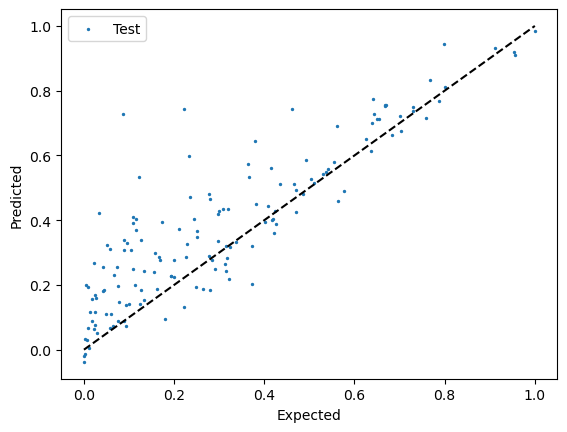

In [14]:
# Plot scatter plot
plt.figure()
# plt.scatter(train_expected, train_predicted, label="Training", s=2)
# plt.scatter(val_expected, val_predicted, label="Validation", s=2)
plt.scatter(test_expected, test_predicted, label="Test", s=2)
plt.plot([min(test_expected), max(test_expected)], [min(test_expected), max(test_expected)], 'k--')  # 'k--' denotes a black dashed line
plt.xlabel("Expected")
plt.ylabel("Predicted")
plt.legend()
plt.show()

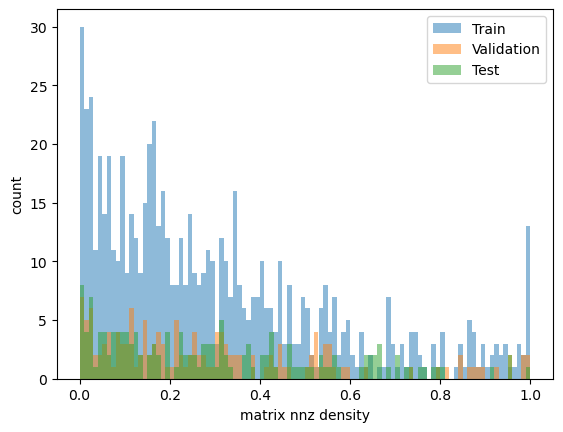

In [12]:
# Draw histogram from the data(nnz density distirbution)
plt.figure()
plt.hist(train_expected, bins=100, alpha=0.5, label="Train")
plt.hist(val_expected, bins=100, alpha=0.5, label="Validation")
plt.hist(test_expected, bins=100, alpha=0.5, label="Test")
plt.xlabel("matrix nnz density")
plt.ylabel("count")
plt.legend()
plt.show()